In [12]:
import matplotlib.pyplot as plt
import numpy as np

import datasets
from regression import OnlineGradientDescent, DimensionFreeExponentiatedGradient, AdaptiveNormal
from regression import CoinBetting, CoinBettingWithFixedDepthSideInformation, CoinBettingWithQuantizedHint
from regression import ContextTreeWeighting

%load_ext autoreload
%autoreload 2

plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Reproducing (Orabona and Pal, 2016)

In [13]:
data = datasets.CpuSmall(root='../', standardize=False,
                         normalize=True, batch_normalize=False)  # default preprocessing used in (Orabona and Pal, 2016)
dim = data.X.shape[1]

# random permutation
perm = np.random.permutation(data.X.shape[0])
X, y = data.X[perm], data.y[perm]
# X, y = data.X, data.y

In [14]:
ogds = dict()
lr_scales = np.array([1.5 ** n for n in range(20)])
for lr_scale in lr_scales:
    ogds[lr_scale] = OnlineGradientDescent(dim=dim, lr_scale=lr_scale).fit_batch(X, y)

In [15]:
dfeg = DimensionFreeExponentiatedGradient(dim=dim).fit_batch(X, y)
adanorm = AdaptiveNormal(dim=dim).fit_batch(X, y)

In [16]:
init_wealth = 100
coin = CoinBetting(dim=dim, init_wealth=init_wealth).fit_batch(X, y)

In [9]:
quantizer_vector = np.zeros(data.X.shape[1])
quantizer_vector[-1] = 1

In [10]:
depths = np.arange(1, 24, 2)
coin_side_information = dict()
for depth in depths:
    coin_side_information[depth] = CoinBettingWithFixedDepthSideInformation(
        dim=dim, init_wealth=init_wealth, quantizer_vector=quantizer_vector, depth=depth).fit_batch(X, y)

coin_hint = CoinBettingWithQuantizedHint(
    dim=dim,
    init_wealth=init_wealth,
    quantizer_vector=quantizer_vector).fit_batch(X, y)

In [17]:
ctws = dict()
max_depths = np.arange(1, 24, 2)
for max_depth in max_depths:
    ctws[max_depth] = ContextTreeWeighting(
        dim=dim,
        init_wealth=init_wealth,
        quantizer_vector=quantizer_vector,
        max_depth=max_depth).fit_batch(X, y)

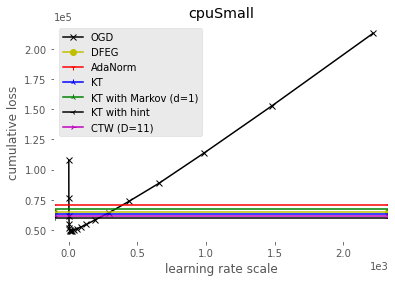

In [18]:
plt.plot(lr_scales, [ogds[lr_scale].cumulative_loss for lr_scale in lr_scales], color='k', marker='x', label='OGD')
plt.axhline(dfeg.cumulative_loss, color='y', marker='o', label='DFEG')
plt.axhline(adanorm.cumulative_loss, color='r', marker='1', label='AdaNorm')
plt.axhline(coin.cumulative_loss, color='b', marker='2', label='KT')
plt.axhline(coin_side_information[depths[0]].cumulative_loss, color='g', marker='2', label='KT with Markov (d={})'.format(depths[0]))
plt.axhline(coin_hint.cumulative_loss, color='k', marker='3', label='KT with hint')
plt.axhline(ctws[5].cumulative_loss, color='m', marker='4', label='CTW (D={})'.format(max_depths[5]))
plt.xlabel('learning rate scale')
plt.ylabel('cumulative loss')
plt.legend()
plt.gca().patch.set_facecolor('white')
plt.title(data.name)
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

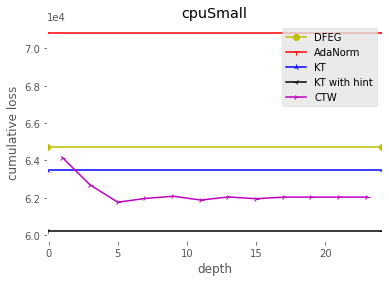

In [19]:
plt.axhline(dfeg.cumulative_loss, color='y', marker='o', label='DFEG')
plt.axhline(adanorm.cumulative_loss, color='r', marker='1', label='AdaNorm')
plt.axhline(coin.cumulative_loss, color='b', marker='2', label='KT')
plt.axhline(coin_hint.cumulative_loss, color='k', marker='3', label='KT with hint')
plt.plot(max_depths, [ctws[max_depth].cumulative_loss for max_depth in max_depths], color='m', marker='4', label='CTW')
plt.xlabel('depth')
plt.ylabel('cumulative loss')
plt.legend()
plt.gca().patch.set_facecolor('white')
plt.title(data.name)
# plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

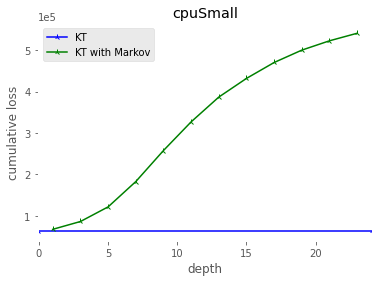

In [20]:
plt.axhline(coin.cumulative_loss, color='b', marker='2', label='KT')
plt.plot(max_depths, [coin_side_information[max_depth].cumulative_loss for max_depth in max_depths], color='g', marker='2', label='KT with Markov')
plt.xlabel('depth')
plt.ylabel('cumulative loss')
plt.legend()
plt.gca().patch.set_facecolor('white')
plt.title(data.name)
# plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

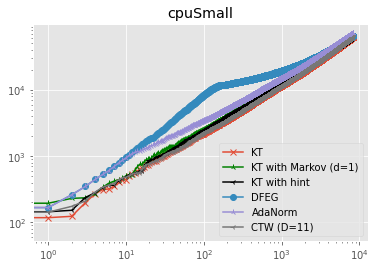

In [21]:
T = data.X.shape[0]
ts = np.arange(1, T+1)
plt.plot(coin.losses.cumsum(), 'x-', label='KT')
plt.plot(coin_side_information[depths[0]].losses.cumsum(), color='g', marker='2', label='KT with Markov (d={})'.format(depths[0]))
plt.plot(coin_hint.losses.cumsum(), color='k', marker='3', label='KT with hint')
plt.plot(dfeg.losses.cumsum(), 'o-', label='DFEG')
plt.plot(adanorm.losses.cumsum(), '2-', label='AdaNorm')
plt.plot(ctws[max_depths[5]].losses.cumsum(), '3-', label='CTW (D={})'.format(max_depths[5]))
plt.title(data.name)
plt.xscale('log')
plt.yscale('log')
plt.legend()

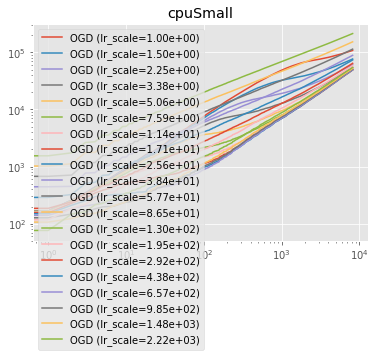

In [22]:
for lr_scale in lr_scales:
    plt.plot(ogds[lr_scale].losses.cumsum(), label='OGD (lr_scale={:.2e})'.format(lr_scale))
plt.title(data.name)
plt.xscale('log')
plt.yscale('log')
plt.legend()

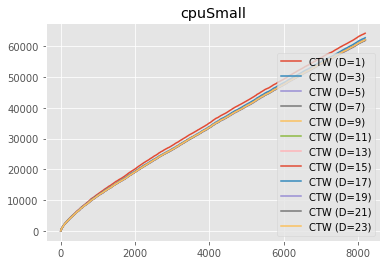

In [23]:
for max_depth in max_depths:
    plt.plot(ctws[max_depth].losses.cumsum(), label='CTW (D={})'.format(max_depth))

plt.title(data.name)
# plt.xscale('log')
# plt.yscale('log')
plt.legend()

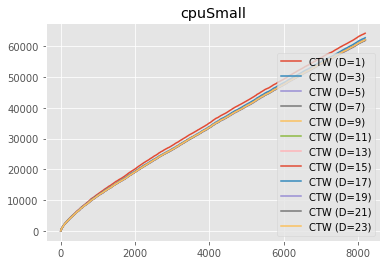

In [24]:
for max_depth in max_depths:
    plt.plot(ctws[max_depth].losses.cumsum(), label='CTW (D={})'.format(max_depth))

plt.title(data.name)
# plt.xscale('log')
# plt.yscale('log')
plt.legend()
